# Pairs Trading Strategy 
In this notebook, we will create a pairs trading strategy using two commodities(Lead and Aluminium) future data from April 2014 to July 2016.  

### Trading Strategy based on Pairs trading

* We know that arbitrage in comodities can be found by three instances: cash and carry, future calendar spread, and inter-commodity arbitrage. Our focus will be inter-commodity arbitrage. 
* By considering different commodities on the same exchange having same cash flow or in the same category, there is a possibility for creating an inter-commodity arbitrage. One example could be the pair comodity Lead and Aluminium.
* The strategy suggests to take positions against the general norms of the market, short the overperforming asset, go long the underperforming one.
* The idea is that cointegrated assets are mean-reverting in nature. So the underperformance asset that we bought is expected to rise meanwhile the one sold is expected to fall back to its mean.
* Cointegrated assets are found when the spread of the portfolio is stationary. Nonetheless, not any arbitrary combination of the portfolio instruments will be stationary. Only some combinations of the instruments are stationary and hence the instruments cointegrated.
* To find a linear combination, we use a Linear Regression and check if the spread is stationary by using the augmented dicker-fuller test. 
* The lookback period chose was 90 days to avoid the look-ahead bias. 
* We used a threshold and z-score (how many std away is the variable from the mean) to decide when to enter a position. 
* We used Stop loss, take profit  and cointegration Break to exit the position. 

## Library imported

In [1]:
import warnings

warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import statsmodels.api as stat
import statsmodels.tsa.stattools as ts

import pyexcel
import pyfolio 

import quandl  # was first used to get the futures commodities data

from tabulate import tabulate

## Import the data
We gathered futures commodities (Aluminum and Lead) data from quandl which later on the data was stored on csv files. 

In [2]:
aluminium_prices = pd.read_csv( "MCX_data_Aluminium_April_2014_to_July_2016.csv", index_col = [0] )
aluminium_prices.index = pd.to_datetime(aluminium_prices.index)

lead_prices = pd.read_csv( "MCX_data_Lead_April_2014_to_July_2016", index_col = [0] )

lead_prices.index = pd.to_datetime( lead_prices.index)

## Clean the data and ensure we only have data for common dates only

In [3]:
# Clean the fetched data
# remove the data where we did not have any value
aluminium_prices = aluminium_prices.dropna()
lead_prices = lead_prices.dropna()

# a key column will be used to make the data uniform date wise
aluminium_prices['key'] = aluminium_prices.index
lead_prices['key'] = lead_prices.index

# Merge the data so we have common dates
result = pd.merge( aluminium_prices, lead_prices, on ='key', left_index = True, right_index = True)
result.head()

,Open_x,High_x,Low_x,Close_x,Volume_x,Open Interest_x,key,Open_y,High_y,Low_y,Close_y,Volume_y,Open Interest_y
Date,,,,,,,,,,,,,
2014-04-01,106.00,106.70,105.65,106.25,5022.0,2282.0,2014-04-01,124.25,124.25,122.35,124.40,8458.0,2528.0
2014-04-02,106.00,108.45,105.90,106.35,8147.0,3343.0,2014-04-02,122.50,123.70,122.10,122.45,9275.0,2559.0
2014-04-03,108.15,110.10,108.00,108.40,7821.0,3384.0,2014-04-03,123.00,124.30,122.45,123.00,10047.0,2424.0
2014-04-04,109.60,110.35,108.05,109.60,6639.0,3144.0,2014-04-04,124.30,124.75,123.00,124.20,9162.0,2734.0
2014-04-07,108.00,109.90,107.80,108.00,6874.0,3208.0,2014-04-07,123.30,124.25,123.00,123.35,8829.0,2752.0


In [4]:
# now place the data back 
aluminium_prices = result[['Open_x', 'High_x', 'Low_x', 'Close_x', 'Volume_x']]
lead_prices = result[ ['Open_y', 'High_y', 'Low_y', 'Close_y', 'Volume_y'] ]

# set the columns as they where before
aluminium_prices.columns = ['Open', 'High', 'Low','Close','Volume']
lead_prices.columns = ['Open','High', 'Low', 'Close','Volume']

### Plot Aluminium and Lead close prices

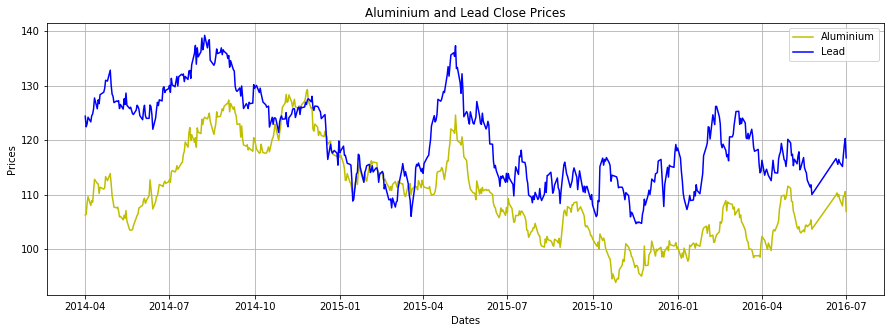

In [5]:
plt.figure( figsize = (15,5) )
plt.plot( aluminium_prices['Close'], 'y', label = "Aluminium" )
plt.plot( lead_prices['Close'], 'b', label = "Lead")
plt.ylabel( "Prices" )
plt.xlabel( "Dates" )
plt.legend()
plt.title( "Aluminium and Lead Close Prices" )
plt.grid(True)
plt.show()

## Plot the Spread of Aluminimum and Lead Close Prices

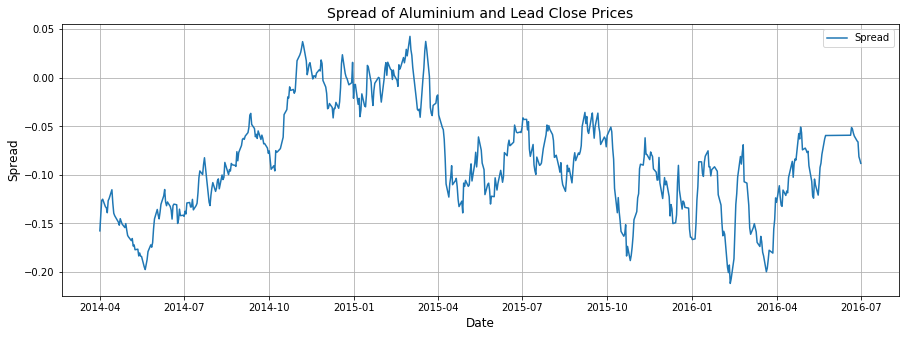

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))

# Plot the spread
ax.plot(aluminium_prices.index, np.log(
    aluminium_prices.Close.values/lead_prices.Close.values), label='Spread')

plt.legend()
plt.xlabel('Date', fontsize=12)
plt.ylabel('Spread', fontsize=12)
plt.title('Spread of Aluminium and Lead Close Prices', fontsize=14)
plt.grid()
plt.show()

## Define helper functions for implementing the trading strategy 
Before we implement the strategy we need some helper functions

### Cointegration test function
We will test if the pair assets are co-integrated by checking if the spread between them is stationary. To check this condition, we will perform an Augmented Dicker-Fuller test. 
Recall that pairs trading strategy is a contrarian strategy designed to harness mean-reverting behavior of cointegrated instruments. Hence, if we get that our pair assets is NOT co-integrated, we will not have an incentive to implement the trading strategy as the pair will not be mean-reverting.

In [7]:
def cointegration_test(x,y):
    """
    This function takes as inputs two dataframes x and y. 
    Runs a linear regresion on the input data Close prices to find the spread.
    Then run an adfuller test to check if the spread is stationary so we can determine if two
    variables are cointegrated.
    """
    # First we use the OLS method to find a spread between x and y. 
    spread = stat.OLS( x['Close'], y['Close'] ).fit()
    
    # Then perform an ADF-test to check if the spread is stationary or not.
    return ts.adfuller( spread.resid )

### Define the z-score function for the spread
We will calculate the z-score for the log price ratio of our commodity pair. The Z-scores will help us to generate trading signals. 

In [8]:
def z_score_function( data1, data2, start, end):
    """
    This function takes two dataframes data1, data2 and two integers 
    start and end which represent index values. It calculates the z-score.
    """
    
    # Get the close prices from the two dataframes as a serie
    # of the last (start -end -1) days. In our case we are going to use the
    # last 10 days.
    s1 = pd.Series( data1['Close'].iloc[start:end] ) # the last 10 Close prices of commodity one
    s2 = pd.Series( data2['Close'].iloc[start:end] ) # the last 10 Close prices of commodity two
    
  #--------------------Now we need to calculate the necessary components for calculating the z-score--------------------

    # compute the moving average of the log of price ratio for the previous 10 data points 
    moving_avg_log_price_ratio = np.mean( np.log(s1/s2)  )
    
    # compute the standard deviation of the log of price ratio for the same 10 data points
    std_log_price_ratio = np.std( np.log(s1/s2)  )
    
    # compute the current log of price ratio of our commodity pair.
    current_log_price_ratio = np.log( data1['Close'][end]/data2['Close'][end]  ) # which is the spread
    
    # Compute the z-score of the log of price ratio for our commodity pair
    z_score = ( current_log_price_ratio - moving_avg_log_price_ratio)/ std_log_price_ratio if std_log_price_ratio > 0 \
                else 0 
    
    return z_score

### Use the z_score function to generate trading signal 
We will generate trading signals based on the z-scores and the predefined threshold. Of course, we need to check if our 
pairs are still cointegrated. 

In the case our z-score is greater than the pre-defined threshold and the pair is still cointegrated, we sell the spread as we expect the spread to fall back to its mean. 
For the case our z-score is less than the pre-defined threshold and the pair is still cointegrated, we buy the spread as we expect the spread to rise back to its mean. 

In [9]:
def generate_signals(zscore, threshold, adftest): 
    '''
    This function takes as inputs two floating points zscore and threshold and a string adftest. 
    It generates trading signals according with the threshold and the mean-reversion property. 
    '''
    if zscore > threshold and adftest == 'Yes':
        # Since the zscore (the number of std the spread is away from its mean) is greater than our predefined
        # threshold and the spread is still stationary then our assumption is that the spread will fall back
        # to the mean and therefore we sell. 
       
        signal = "Sell" # For our case: means go short on Aluminium futures and go long on Lead futures.
    
    elif zscore < -threshold and adftest == 'Yes':
        # Since the zscore (the number of std the spread is away from its mean) is less than our predifined 
        # threshold and the spread is still stationary then our assumption is that the spread will rise back
        # to the mean and therefore we buy. 
    
        signal = "Buy" # For our case: means go long on Aluminium futures and go short on Lead futures.
    
    else: # For any other cases, there is no need to trigger any trading signals as either the z-score does not 
          # exceed the threshold or the ADF test indicates an absent of cointegration.
        signal = ""
        
    return signal

### Update status for a trading day using following codes

We know that pairs trading strategy is exposed to several risks. Statistical Arbitrage depends on the assets being cointegrated. However, if the spread does not return to its mean, then there is a chance of losses in profits. For managing this risk exposure we can set a stop loss and close our position. For reducing risk exposure, we can set a co-integration break to identify whenever the pair commodity asset stops being cointegrated and close our position. Also, we need to find when to trigger a take profit.  

Hence, we need to define when to trigger a stop loss, take profit or co-integration break in order to close our position. 

In general our rules will be: 

    Update status for a trading day
        1. As SL if MTM is less than SL
        2. And as TP if MTM > TP
        3. Check for cointegration break as well

where: SL = Stop Loss, TP = Take Profit, CB = Co-integration Break


In [10]:
def status_update_function(prev_status, mtm, SL, TP, signal, adftest):
    """
    This function takes as inputs a string representing the prev_status, another 
    string that represent the current trading signal, three floating points for mtm, SL, TP 
    and a string that represents the result of the adftest. The function return the current 
    status of the trading strategy based on the rules that trigger our SL, TP or co-integration
    break status. 
    """
    
    # if our previous status is blank, SL, TP, and CB, the our status is the same our signal
    if prev_status in ["", "SL", "TP", "CB"]:
        status = signal        
    else:
        if adftest == "No": # the pair is no longer co-integrated
            status  = "CB" # set the status as co-integration break 
        else: # else the pairs are co-integrated
            if mtm == "": # we don't have signals yet so set the status as empty
                status = ""
            else:
                if mtm < SL: # the stop loss is triggered
                    status = "SL"
                else:  
                    if mtm > TP: # the take profit is triggered
                        status = "TP"
                    else: # we keep the previus status
                        status = prev_status 
                        
                        
    return status

### Define the Buy price function
In the case:
1. We have a BUY signal, the buy price is the close price of the FIRST security.
2. We have a SELL signal, the buy price is the close price of the SECOND security.

In [11]:
def buy_price_function( prev_status, prev_buy_price, buy_price, signal, status, data1, data2, end): 
    """
    This function takes the previous status, previous buy price, buy price, and the signal status
    to determine the buy price of the spread. Since the buy price of the spread will come from the
    two dataframes, we also have the dataframes data1 and data2 with and end index  
    to determine the buy price. It returns the buy price of the spread.
    """
    if status == prev_status: # we keep the same buy price as before
        buy_price = prev_buy_price 
    else:
        
        if status in ["", "SL", "TP", "CB"]: # if this is true then we set it blank 
                                          # since we are looking to exit a trade or have not take any position yet.
            buy_price= ""
            
        else:
            if signal == "Buy": # the signal says to buy the spread 
                               # then the buy price == close price of the first security(Aluminium)
                buy_price = data1['Close'][end]
            else: 
                if signal == "Sell":  # the signal says to sell the spread
                                      # the the buy price == close price of the second security (Lead)
                    buy_price = data2['Close'][end] 
                else:
                    buy_price = ""  # no signal hence no buy price
                    
                    
    return buy_price

### Define the Sell price function
The sell price function performs the opposite of the buy function.
In the case: 

    1. For a BUY signal on the spread, the SELL PRICE is the close price of the SECOND security. 
    2. For a SELL signal on the spread, the SELL PRICE is the close of the first security. 

In [12]:
def sell_price_function(prev_status, prev_sell_price, sell_price,signal, status, data1, data2, end):
    """
    This function takes the previous status, previous sell price, sell price, and the signal status
    to determine the sell price of the spread. Since the sell price of the spread will come from the
    two dataframes, we also have the dataframes data1 and data2 with and end index  
    to determine the sell price. It returns the sell price of the spread.
    """
    
    if status == prev_status: # we keep the same sell price as before
        sell_price = prev_sell_price 
    else: 
        if status in ["", "SL", "TP", "CB"]:  # if this is true then we set it blank 
                                          # since we are looking to exit a trade or have not take any position yet.
            sell_price = ""
        else:
            if signal == "Buy":  # Signal is to buy the spread, 
                                # then the sell price == the close price of the second security
                sell_price = data2['Close'][end] 
            else:
                if signal == "Sell": # Signal is to sell the spread,
                                     # then the sell price == the close price of the first security
                    sell_price = data1['Close'][end]
                else:
                    sell_price = "" # no signal hence no sell price
            
    return sell_price

### Define the MTM calculation function using lot sizes
We know that MTM stands for mark to market. In this case, MTM is the fair value of the portfolio based on the realized market price of its constituents. We will only calculate the mtm if the previous status is Buy or Sell. The MTM is calculated by closing the positions with the current prices of the commodity pair. 

When we have a buy status, we have the opening positions of:
 * Long aluminium 
 * and Short lead.

To calculate the mtm, we need to close those positions. 
Hence, 
* close the short lead position by
  mtm_m == the mtm of lead == (previous sell price of Lead - current sell price of Lead)* lot size of Lead
* close the long alumimiun by
  mtm_n == the mtm of Aluminimium == (current buy price of Aluminium - previous buy price of Aluminium)*Lot size
        
When we have a sell status, we have the opening positions of:
 * Short aluminium 
 * and Long lead.

To calculate the mtm, we need to close those positions. 
Hence, 
* close the short aluminium position by
  mtm_n == the mtm of Aluminium = (previous sell price of Aluminiumm -current sell price of Aluminium)*lot size of Aluminium
* close the long lead position by 
   mtm_m == the mtm of Lead = (current buy price of Lead - previous buy price of Lead)* Lot size of Lead   
   
We used:

        M=5000 : lot size for data1
        N=5000 : lot size for data2

In [13]:
def mtm_calculate_function(data1, data2, prev_status, prev_sell_price, prev_buy_price, M, N, end):
    """
    The function takes as input two dataframes data1 and data2 (which contains the data from the pair commodity), 
    3 floating points prev_status, prev_sell_price, prev_buy_price, 
    and 3 integers M, N which represents the lot size of the two commodities and end which is an index number.
    This function return the mark to market value. 
    """
    
    # We start by checking the previous status 
    # if it is buy or sell then we calculate the mtm. If not the case we leave it blank.
    if prev_status == "Buy":
        # when we have a buy status, we have the opening positions of Long 
        # aluminium and short lead. To calculate the mtm, we need to close those positions
        
            # close the short lead position by
            #  mtm_m == the mtm of lead =  (previous sell price of Lead - current sell price of Lead)* lot size of Lead
        mtm_m = (prev_sell_price - data2['Close'][end])*M   
        
            # close the long alumimiun by
            # mtm_n == the mtm of Aluminimium = (current buy price of Aluminium - previous buy price of Aluminium)*Lot size
        mtm_n = (data1['Close'][end] - prev_buy_price)*N # close the long aluminium position
        
        # add the two separated mtm
        mtm = mtm_m + mtm_n 
        
        return mtm
    else:
        if prev_status == "Sell":
            # when we have a sell status, we have the opening positions of short aluminium and long lead.
            # To calculate the mtm, we need to close those positions.
            
            # close the short aluminium position by
            # mtm_n == the mtm of Aluminium = (previous sell price of Aluminiumm -current sell price of Aluminium)*lot size
            mtm_n = (prev_sell_price - data1['Close'][end])*N  
            
            # close the long lead position by 
            # mtm_m == the mtm of Lead = (current buy price of Lead - previous buy price of Lead)* Lot size of Lead
            mtm_m = ( data2['Close'][end] - prev_buy_price)*M
            
            # add the two separated mtm
            mtm = mtm_n + mtm_m
            return  mtm        
        else:
            mtm = ""
    
    return mtm

## Implementing the trading strategy

1. Start from a look-back period of 90 days
2. Check for cointegration
3. Calculate z-score for the spread
4. Generate the signals
5. Calculate MTM for the day if applicable
6. Calculate Status, buy price and sell price
7. Calculate PnL

Save the dataframe as CSV file for debugging purposes


In [14]:
def implement_pairs_trading_strategy(data1, data2, threshold, start, end, 
                                    prev_status, mtm, prev_sell_price, sell_price, 
                                    prev_buy_price, buy_price, SL, TP, M,N):
    """
    This function will implement the pairs trading strategy and store the data in 
    a csv file.
    """
    
    pnl = 0 
    i = 0 
    
    
    for row in data1[90:].iterrows():
        
        # Run the Adf test for each day, starting at day 91 
        d1 = data1[i:90+i]
        d2 = data2[i:90+i]
        
        coint_test = cointegration_test(d1,d2)     
        
        # 2) Check for cointegration
        if coint_test[0] <= coint_test[4]['10%'] and coint_test[1] <= 0.1: 
            adftest = "Yes"
        else:
            adftest = "No"
            
            
        # 3) Calculating the z-score 
        zscore = z_score_function(data1,data2, start,end) 
        
        
        # 4) Generating trading signal 
        signal = generate_signals(zscore, threshold, adftest) 
        
        # 5) Calculate the MTM if applicable 
        mtm = mtm_calculate_function(data1, data2, prev_status, prev_sell_price,
                            prev_buy_price, M, N, end)
        
        # 6.1) Calculate the Status 
        status = status_update_function(prev_status, mtm,SL, TP,signal, adftest)
        
        # 6.2) Calculate the buy price
        buy_price = buy_price_function( prev_status, prev_buy_price, buy_price, 
                                       signal, status, data1,data2, end)
        
        # 6.3) Calculate the sell price 
        sell_price = sell_price_function( prev_status, prev_sell_price, sell_price,
                                         signal, status, data1, data2, end) 
        
        # 7) Calculate the PNL 
        pnl = (pnl + mtm) if status in ['SL', 'TP', 'CB'] else pnl
        
        
        # Assigning the previous values
        prev_status = status
        prev_sell_price = sell_price 
        prev_buy_price = buy_price 
        
        
        # Append the value to the array data
        data.append( [    str( data1.index[end] )[:10] , data1['Close'][end],
                          data2['Close'][end], zscore, signal, status, buy_price,
                          sell_price, mtm, pnl, adftest
                     ]
                   )
        # Increment the iterator variables to consider the next set of data.
        end += 1 
        start += 1
        i += 1
        
        
    # Save it to a csv for debugging and record purposes 
    pyexcel.save_as( 
       array = data, dest_file_name = "pair_strategy_record.csv" )

## Initialize variables

In [15]:
data = []
headers = ['Date', 'commodity1', 'commodity2', 'zscore', 'signal', 'status',
           'buy price', 'sell price', 'mtm', 'pnl', 'Cointegration test']

data.append(headers)
threshold = 1.75    # Tolerance for the stdev above and below the mean
start = 80
end = 90
prev_status = ""
mtm = ""
prev_sell_price = ""
sell_price = ""
prev_buy_price = ""
buy_price = ""
SL = -10000      # Stop loss
TP = 20000       # Take profit
N = 5000           # Lot size for data1
M = 5000           # Lot size for data2

## Implement the strategy

In [16]:
implement_pairs_trading_strategy(aluminium_prices,lead_prices,threshold,start,end,prev_status,mtm,prev_sell_price,\
             sell_price,prev_buy_price,buy_price,SL,TP,M,N) 


## Backtesting the strategy and plotting the cumulative PNL 

#### Plotting the cumulative PNL

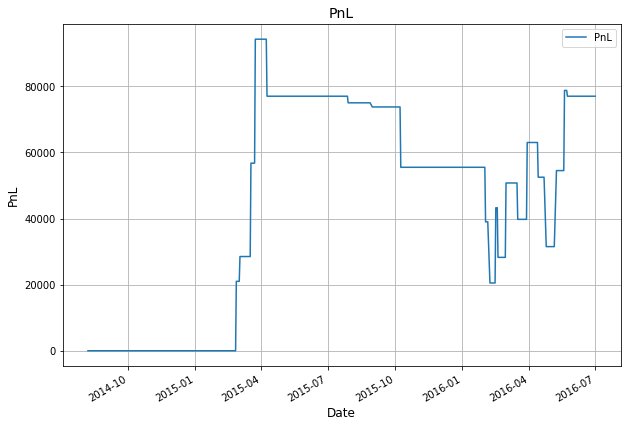

In [17]:
result = pd.DataFrame(data, columns=headers)[1:] # Ignore the first row
result.set_index('Date',inplace=True)  # Set Date column as index for better plotting
result.index = pd.to_datetime(result.index) # Convert index to a datetime index

result.pnl.plot(figsize=(10,7), label ='PnL') 
plt.legend() 
plt.xlabel('Date', fontsize=12)
plt.ylabel('PnL', fontsize=12)
plt.title('PnL', fontsize=14)
plt.grid() 
plt.show()

#### Calculate the strategy profitability metrics 
Calculate the positive trades, negative trades, total trades, hit_ratio, sharpe_ratio of the trading strategy. 

In [18]:
result['MTM'] = np.where( result['mtm'] != "", result['mtm'], 0 )
result['Positive Trade'] = np.where( result['MTM'] > 0, 1, 0 )
result['Negative Trade'] = np.where( result['MTM'] < 0, 1, 0 )

positive_trades = result['Positive Trade'].sum()
negative_trades = result['Negative Trade'].sum()
total_trades = positive_trades + negative_trades

hit_ratio = positive_trades/total_trades 

result['Hit_Ratio'] = hit_ratio

result['Sharpe_Ratio'] = result['MTM'].mean()/result['MTM'].std()*252**0.5

sharpe_ratio = result['Sharpe_Ratio'].iloc[-1]

pnl = result['pnl'].iloc[-1]

In [19]:
# Store the Summary result in a nested list
Summary = [ ["Number of Trades", total_trades] , 
            ["Number of Positive Trades", positive_trades] , 
            ["Number of Negative Trades", negative_trades], 
            ["Hit Ratio", round( hit_ratio,4 ) ] , 
            ["Sharpe Ratio", round( sharpe_ratio,4) ],
            ["Total PNL", pnl ]
          ]

# Print the results in a nice table
print("\t\t    Summary")
print("_____________________________________________")
print(tabulate(Summary ,
        headers=['Trading Parameters','Value'],tablefmt='orgtbl'))

		    Summary
_____________________________________________
| Trading Parameters        |      Value |
|---------------------------+------------|
| Number of Trades          |    94      |
| Number of Positive Trades |    47      |
| Number of Negative Trades |    47      |
| Hit Ratio                 |     0.5    |
| Sharpe Ratio              |     1.5497 |
| Total PNL                 | 77000      |


## Conclusion

* The performance for this trading strategy was acceptable. 
* The cumulative PNL was 77000 INR without taking in considarition transaction costs and other fees. 
* We did in total 94 trades in which 47 were positives and 47 were negatives.
* Hence, the hit ratio was 0.5. 
* The Sharpe ratio was 1.5497 which is greater than one. Any sharpe ratio greater than one is considerated as acceptable since sharpe ratio represents the return we are generating for each unit of risk taken. 